<a href="https://colab.research.google.com/github/mobarakol/tutorial_notebooks/blob/main/img_depth_intrisic_3d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import gdown
import os
import cv2
import matplotlib.pyplot as plt

url = 'https://drive.google.com/uc?id=1xvLTf6tFcIcCCWJnNZdIOqC0-gqDPsQ3'
gdown.download(url,'pointcloud_end17.zip',quiet=True)
!unzip -q pointcloud_end17.zip


In [ ]:
!pip -q install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 65.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 88.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.7 MB/s eta 0:00:00


In [ ]:
from transformers import DPTFeatureExtractor, DPTForDepthEstimation
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
feature_extractor = DPTFeatureExtractor.from_pretrained("Intel/dpt-large")
depth_estimation = DPTForDepthEstimation.from_pretrained("Intel/dpt-large").to(device)

/usr/local/lib/python3.10/dist-packages/transformers/models/dpt/feature_extraction_dpt.py:28: FutureWarning: The class DPTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DPTImageProcessor instead.
  warnings.warn(


Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution2.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(640, 800, 3)
torch.Size([1, 3, 384, 384])


True

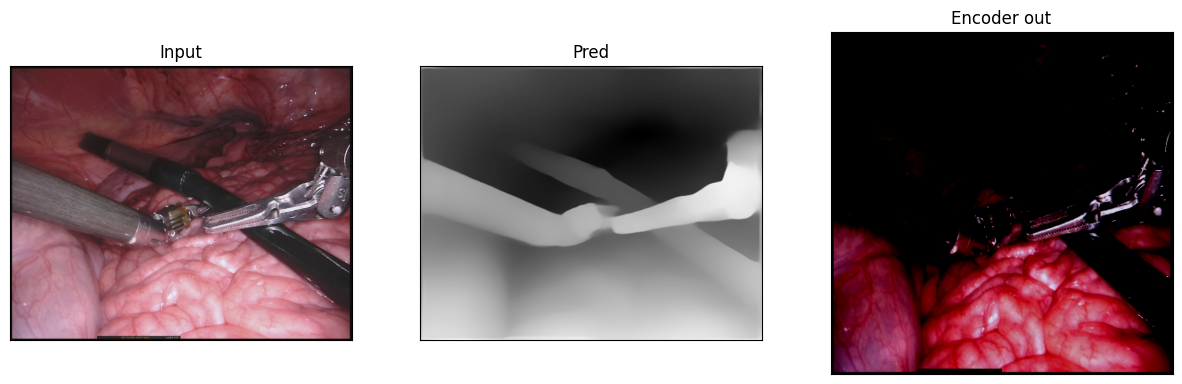

In [ ]:

from glob import glob
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import tifffile
import cv2
import gdown
import os

image_raw = Image.open('/content/pointcloud/labeltool/instrument_dataset_1/left_crop/frame004.png').convert('RGB')
# image_raw = transforms.ToPILImage()(img)#[None]
image = image_raw.resize((800, int(800 * image_raw.size[1] / image_raw.size[0])), Image.LANCZOS)# Image.Resampling.LANCZOS)
print(np.array(image).shape)
encoding = feature_extractor(image, return_tensors="pt").to(device)
print(encoding['pixel_values'].shape)
with torch.no_grad():
    outputs = depth_estimation(**encoding)
    # print(outputs.__dict__.keys())#['loss', 'predicted_depth', 'hidden_states', 'attentions']
    predicted_depth = outputs.predicted_depth
    prediction = torch.nn.functional.interpolate(
        predicted_depth.unsqueeze(1),
        size=image_raw.size[::-1],
        mode="bicubic",
        align_corners=False,
    ).squeeze()
output = prediction.cpu().numpy()

num_img = 3
fig, ax = plt.subplots(1, num_img, figsize=(5*num_img,5), subplot_kw=dict(xticks=[],yticks=[]))
ax[0].imshow(image)
ax[0].set_title('Input')
ax[1].imshow(output, cmap='gray')
ax[1].set_title('Pred');
ax[2].imshow(encoding['pixel_values'][0].permute(1,2,0).cpu(), cmap='gray')
ax[2].set_title('Encoder out');
cv2.imwrite('depth_04.png', output)

In [ ]:
import numpy as np
visual = (output - output.min()) / (output.max() - output.min())
result = Image.fromarray((visual * 255).astype(np.uint8))
result.save('dept_04.png')
# image_raw = transforms.ToPILImage()(output).convert('L')
# image_raw.save('test.png')

In [ ]:
image_raw = Image.open('/content/pointcloud/labeltool/instrument_dataset_1/left_crop/frame004.png').convert('RGB')
np.array(image_raw).max()

255

In [ ]:
visual.min(), visual.max(), np.array(image_raw).max()

(0.0, 1.0, 23)

In [ ]:
output.max(), output.min()

(23.333609, 6.132216)

In [ ]:
!pip -q install open3d
import open3d as o3d
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np


# rgbd
disp = np.array(Image.open("/content/dept_04.png"))
img = np.array(Image.open("/content/pointcloud/labeltool/instrument_dataset_1/left_crop/frame004.png"))
depth_o3d = o3d.geometry.Image(disp)
image_o3d = o3d.geometry.Image(img)
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
    image_o3d, depth_o3d, convert_rgb_to_intensity=False)

# intrinsic
h = int(disp.shape[0])
w = int(disp.shape[1])
camera_intrinsic = o3d.camera.PinholeCameraIntrinsic()
camera_intrinsic.set_intrinsics(w, h, 1068.39, 1068.19, 600.90, 500.74)#(w, h, Fx, Fy, Cx, Cy)
# camera_intrinsic.set_intrinsics(w, h, 500, 500, w/2, h/2)#500, 500, 640,512
# camera_intrinsic.set_intrinsics(w, h, 1035, 1035, 597, 520)#1035, 1035, 597,520
print('intrinsic:\n', camera_intrinsic.intrinsic_matrix)

# invalidate existing normals
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, camera_intrinsic)
pcd.normals = o3d.utility.Vector3dVector(np.zeros((1, 3)))
pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.01, max_nn=30))
pcd.orient_normals_towards_camera_location(camera_location=np.array([0., 0., 1000.]))
pcd.transform([[1, 0, 0, 0],
                [0, -1, 0, 0],
                [0, 0, -1, 0],
                [0, 0, 0, 1]])
pcd.transform([[-1, 0, 0, 0],
                [0, 1, 0, 0],
                [0, 0, 1, 0],
                [0, 0, 0, 1]])

# run Poisson surface reconstruction
with o3d.utility.VerbosityContextManager(o3d.utility.VerbosityLevel.Debug) as cm:
    mesh_raw, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
        pcd, depth=10, width=0, scale=1.1, linear_fit=True)

voxel_size = max(mesh_raw.get_max_bound() - mesh_raw.get_min_bound()) / 256
print(f'voxel_size = {voxel_size:e}')
mesh = mesh_raw.simplify_vertex_clustering(
    voxel_size=voxel_size,
    contraction=o3d.geometry.SimplificationContraction.Average)

# vertices_to_remove = densities < np.quantile(densities, 0.001)
# mesh.remove_vertices_by_mask(vertices_to_remove)
bbox = pcd.get_axis_aligned_bounding_box()
mesh_crop = mesh.crop(bbox)
mesh_crop = o3d.geometry.TriangleMesh.compute_triangle_normals (mesh_crop)
img_path = "pcd" # 'monodepth2/assets/pcd'
gltf_path = f'./{img_path}.gltf'
stl_path = f'./{img_path}.stl'
o3d.io.write_triangle_mesh("pcd.gltf", mesh_crop, write_triangle_uvs=True)
o3d.io.write_triangle_mesh("pcd.stl", mesh_crop, write_triangle_uvs=True) #ply/stl/obj/off/gltf
mesh = o3d.io.read_triangle_mesh('/content/pcd.stl')
print(mesh)
# o3d.visualization.draw_geometries([mesh_crop])

from google.colab import files

files.download('/content/pcd.stl')
files.download('/content/pcd.gltf')

intrinsic:
 [[1.06839e+03 0.00000e+00 6.00900e+02]
 [0.00000e+00 1.06819e+03 5.00740e+02]
 [0.00000e+00 0.00000e+00 1.00000e+00]]
[Open3D DEBUG] Input Points / Samples: 1309251 / 341595
[Open3D DEBUG] #   Got kernel density: 0.38262009620666504 (s), 4196.5625 (MB) / 4196.5625 (MB) / 4270 (MB)
[Open3D DEBUG] #     Got normal field: 1.467850923538208 (s), 4364.140625 (MB) / 4364.140625 (MB) / 4364 (MB)
[Open3D DEBUG] Point weight / Estimated Area: 1.204333e-06 / 1.576774e+00
[Open3D DEBUG] #       Finalized tree: 2.5814411640167236 (s), 4616.0234375 (MB) / 4616.0234375 (MB) / 4616 (MB)
[Open3D DEBUG] #  Set FEM constraints: 11.698798894882202 (s), 4487.30078125 (MB) / 4616.0234375 (MB) / 4616 (MB)
[Open3D DEBUG] #Set point constraints: 1.0499861240386963 (s), 4487.30078125 (MB) / 4616.0234375 (MB) / 4616 (MB)
[Open3D DEBUG] Leaf Nodes / Active Nodes / Ghost Nodes: 5563349 / 6063904 / 294209
[Open3D DEBUG] Memory Usage: 4487.301 MB
[Open3D DEBUG] # Linear system solved: 13.007905960083008

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

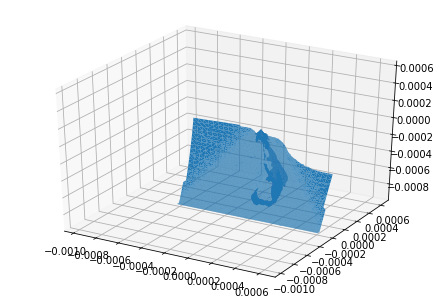

In [ ]:
from stl import mesh
from mpl_toolkits import mplot3d
from matplotlib import pyplot as plt

# Create a new plot
figure = plt.figure()
axes = mplot3d.Axes3D(figure)

# Load the STL files and add the vectors to the plot
mesh = mesh.Mesh.from_file('pcd.stl') # Mesh with 77255 items
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(mesh.vectors))

# Auto scale to the mesh size
points = mesh.points #ndarray with shape (77255, 9)
scale = mesh.points.flatten()
axes.auto_scale_xyz(scale, scale, scale)
plt.show()